In [ ]:
import pandas as pd
import get_fec_data
import importlib
import get_city_data
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

importlib.reload(get_fec_data)
importlib.reload(get_city_data)

from get_fec_data import FECDataFetcher

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
import xgboost as xgb

load_dotenv()

API_KEY = os.getenv('FEC_API_KEY')
CENSUS_API_KEY = os.getenv('CENSUS_API_KEY')
FBI_API_KEY = os.getenv('FBI_API_KEY')

In [ ]:
BASE_URL = 'https://api.open.fec.gov/v1/'
ELECTION_YEARS = [2016, 2018, 2020, 2022]

FEC_PA_Congress = FECDataFetcher(
    api_key=API_KEY,
    base_url=BASE_URL,
    election_years=ELECTION_YEARS,
    state='PA'
)

candidate_details = FEC_PA_Congress.get_candidate_ids()
candidate_df = pd.DataFrame(candidate_details)
committee_ids = [c['committee_id'] for c in candidate_details if c['committee_id']]
print(f"Found {len(candidate_details)} candidates in PA")

candidate_df.head()


Found 90 candidates in PA


,candidate_id,incumbent_challenge,name,party,committee_id
0,H8PA05303,Challenger,"ADDIS, PAUL DAVID",REP,C00647594
1,H8PA01237,Open seat,"AHMAD, NILOFER NINA",DEM,C00662205
2,H2PA10108,Challenger,"ALLEN, BRIAN",REP,C00764985
3,H8PA12077,Challenger,"ANTHONY, AARON",DEM,C00636555
4,H8PA05261,Challenger,"ARATA, LARRY V MR. III",DEM,C00670646


In [3]:
donor_df = FEC_PA_Congress.get_donations(committee_ids, 2)
donor_df.head()

Querying donor data for: C00647594
Params: {'api_key': 'tmogdcHlHwyLxVtS2zHEcfjjEkW7Mq6G0lHdkiaY', 'contributor_state': 'PA', 'per_page': 100, 'two_year_transaction_period': [2016, 2018, 2020, 2022], 'committee_id': 'C00647594'}
Querying donor data for: C00662205
Params: {'api_key': 'tmogdcHlHwyLxVtS2zHEcfjjEkW7Mq6G0lHdkiaY', 'contributor_state': 'PA', 'per_page': 100, 'two_year_transaction_period': [2016, 2018, 2020, 2022], 'committee_id': 'C00662205', 'page': 1}
Querying donor data for: C00662205
Params: {'api_key': 'tmogdcHlHwyLxVtS2zHEcfjjEkW7Mq6G0lHdkiaY', 'contributor_state': 'PA', 'per_page': 100, 'two_year_transaction_period': [2016, 2018, 2020, 2022], 'committee_id': 'C00662205', 'page': 1}
Querying donor data for: C00764985
Params: {'api_key': 'tmogdcHlHwyLxVtS2zHEcfjjEkW7Mq6G0lHdkiaY', 'contributor_state': 'PA', 'per_page': 100, 'two_year_transaction_period': [2016, 2018, 2020, 2022], 'committee_id': 'C00764985', 'page': 2}
Querying donor data for: C00636555
Params: {'api_ke

,amendment_indicator,amendment_indicator_desc,back_reference_schedule_name,back_reference_transaction_id,candidate_first_name,candidate_id,candidate_last_name,candidate_middle_name,candidate_name,candidate_office,...,recipient_committee_org_type,recipient_committee_type,report_type,report_year,schedule_type,schedule_type_full,sub_id,transaction_id,two_year_transaction_period,unused_contbr_id
0,A,ADD,None,None,PAUL,H8PA05303,ADDIS,None,"ADDIS, PAUL",H,...,,H,TER,2018,SA,ITEMIZED RECEIPTS,4071220181575846060,SA11D.4209,2018,None
1,A,ADD,None,None,None,None,None,None,None,None,...,,H,Q1,2018,SA,ITEMIZED RECEIPTS,2050920181547008058,None,2018,None
2,A,ADD,None,None,None,H8PA05303,None,None,None,None,...,,H,YE,2017,SA,ITEMIZED RECEIPTS,2050920181547008034,None,2018,None
3,A,ADD,None,None,None,S8PA00304,None,None,None,None,...,,H,YE,2017,SA,ITEMIZED RECEIPTS,1042220180036554277,None,2018,S8PA00304
4,A,ADD,None,None,None,None,None,None,None,None,...,,H,YE,2017,SA,ITEMIZED RECEIPTS,2050920181547008033,None,2018,None


In [4]:
candidate_donor_df = donor_df.merge(candidate_df, on='committee_id')
candidate_donor_df_filtered = candidate_donor_df[['name', 'party', 'incumbent_challenge', 'contributor_name','contributor_city', 'contributor_state','contributor_employer', 'contributor_occupation', 'two_year_transaction_period', 'contribution_receipt_amount']]
candidate_donor_df_filtered.head()

,name,party,incumbent_challenge,contributor_name,contributor_city,contributor_state,contributor_employer,contributor_occupation,two_year_transaction_period,contribution_receipt_amount
0,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL",HAVERFORD,PA,None,None,2018,17200.0
1,"ADDIS, PAUL DAVID",REP,Challenger,BRIDGE CONNECTIONS,PITTSBURGH,PA,None,None,2018,3150.0
2,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL MR",HAVERFORD,PA,SELF-EMPLOYED,INVESTOR,2018,500000.0
3,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL MR",HAVERFORD,PA,SELF-EMPLOYED,INVESTOR,2018,500000.0
4,"ADDIS, PAUL DAVID",REP,Challenger,"MEYER, THOMAS OTHER",WYNNEWOOD,PA,"PULMONOLOGY ASSOCIATES INC,",MEDICAL DOCTOR,2018,250.0


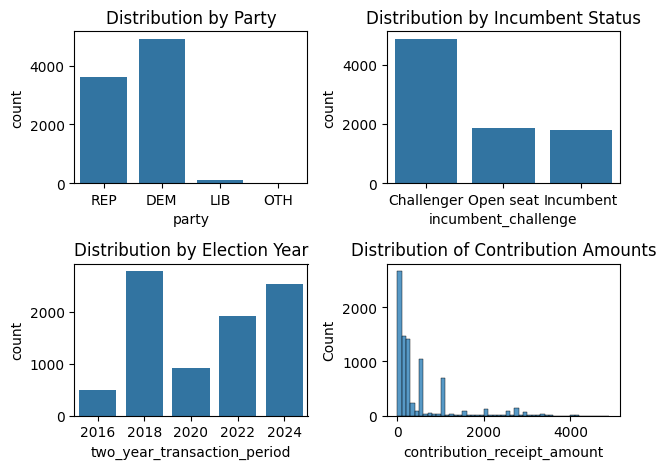

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2)

sns.countplot(data=candidate_donor_df_filtered, x='party', ax=axes[0, 0])
axes[0, 0].set_title('Distribution by Party')

sns.countplot(data=candidate_donor_df_filtered, x='incumbent_challenge', ax=axes[0,1])
axes[0,1].set_title('Distribution by Incumbent Status')

sns.countplot(data=candidate_donor_df_filtered, x='two_year_transaction_period', ax=axes[1,0])
axes[1,0].set_title('Distribution by Election Year')

# Contribution amount distribution
sns.histplot(data=candidate_donor_df_filtered, x='contribution_receipt_amount', bins=range(0, 5000, 100), ax=axes[1,1])
axes[1,1].set_title('Distribution of Contribution Amounts')

plt.tight_layout()
plt.show()

In [ ]:
from census import Census

unique_cities = candidate_donor_df_filtered[['contributor_city', 'contributor_state']].drop_duplicates().reset_index(drop=True)


def get_state_city_fips(census_api_key, state_fips):
    year=2022
    c=Census(census_api_key)

    try:
        places=c.acs5.state_place(
            fields=['NAME'],
            state_fips=state_fips,
            place='*'
        )

        city_data = []
        for place in places:
            city_data.append({
                'place_name': place['NAME'],
                'place_fips': place['place'],
                'state_fips': place['state']             
            })
    except Exception as e:
        print(f"Error fetching PA city FIPS codes: {str(e)}")
        return None
    return pd.DataFrame(city_data)

pa_city_fips = get_state_city_fips(CENSUS_API_KEY, '42')

def resolve_multiple_matches(original_multiple_matches):
    """
    Resolve cities with multiple potential matches using pattern matching and type preferences
    """
    resolved_matches = []
    remaining_multiple_matches = []
    no_matches = []

    # First pass -- prefix matching and city/borough/cdp matching
    for match_entry in original_multiple_matches:
        city_patterns = (f"{match_entry['contributor_city']} CITY", 
                         f"{match_entry['contributor_city']} BOROUGH", 
                         f"{match_entry['contributor_city']} CDP")
        
        new_matches = []
        for match in match_entry['matches']:
            if any(pattern in match.upper() for pattern in city_patterns) and match.upper().startswith(match_entry['contributor_city']):
                new_matches.append(match)

        if len(new_matches) > 1:
            remaining_multiple_matches.append({
                'contributor_city': match_entry['contributor_city'],
                'matches': new_matches
            })
        elif len(new_matches) == 1:
            resolved_matches.append({
                'contributor_city': match_entry['contributor_city'],
                'place_name': new_matches[0]
                })
        else:
            no_matches.append(match_entry['contributor_city'])
    
    # Second pass: selecting based on 1) city 2) borough 3) CDP
    final_remaining_multiple_matches = []
    for entry in remaining_multiple_matches:
        matches = entry['matches']
        
        city_matches = [m for m in matches if 'city' in m.lower()]
        if len(city_matches) == 1:
            resolved_matches.append({
                'contributor_city': entry['contributor_city'],
                'place_name': city_matches[0]})
            continue
            
        borough_matches = [m for m in matches if 'borough' in m.lower()]
        if len(borough_matches) == 1:
            resolved_matches.append({
                'contributor_city': entry['contributor_city'],
                'place_name': borough_matches[0]})
            continue
            
        final_remaining_multiple_matches.append(entry)

    print(f'Resolved multiple matches: {len(resolved_matches)}')
    print(f'Ambiguous multiple matches: {len(remaining_multiple_matches)}')
    print(f'No matches: {len(no_matches)}')
    return resolved_matches, final_remaining_multiple_matches, no_matches

def match_cities_to_fips(unique_cities, pa_city_fips):
    """
    Match cities to their FIPS codes, handling multiple matches and unmatched cities
    """
    matches = []
    multiple_matches = []
    unmatched = []

    pa_city_fips['place_name_upper'] = pa_city_fips['place_name'].str.upper()

    # first pass - direct matching
    for _, row in unique_cities.iterrows():
        try:
            city = row['contributor_city'].upper()
        except:
            continue

        matching_places = pa_city_fips[pa_city_fips['place_name_upper'].str.contains(city, regex=False)]
        
        if len(matching_places) == 1:
            match = matching_places.iloc[0]
            matches.append({
                'contributor_city': row['contributor_city'],
                'contributor_state': row['contributor_state'],
                'place_name': match['place_name'],
                'place_fips': match['place_fips'],
                'state_fips': match['state_fips']
            })
        elif len(matching_places) > 1:
            multiple_matches.append({
                'contributor_city': row['contributor_city'],
                'matches': matching_places['place_name'].tolist()
            })
        else:
            unmatched.append(row['contributor_city'])
    
    # second pass - deal with multiple matches
    resolved_matches, remaining_multiple_matches, no_matches = resolve_multiple_matches(multiple_matches)
    for resolved_place_name in resolved_matches:
        match = pa_city_fips[pa_city_fips['place_name'] == resolved_place_name['place_name']].iloc[0]
        matches.append({
            'contributor_city': resolved_place_name['contributor_city'],
            'contributor_state': 'PA',
            'place_name': match['place_name'],
            'place_fips': match['place_fips'],
            'state_fips': match['state_fips']
        })
    print(f"Total number of matches {len(matches)}")
    print(f"Total remaining multiple matches {len(remaining_multiple_matches)}")
    print(f"Total unmatched locations: {len(unmatched) + len(no_matches)}")
    return matches, remaining_multiple_matches, unmatched + no_matches

matches, multiple_matches, unmatched = match_cities_to_fips(unique_cities, pa_city_fips)
matches_df = pd.DataFrame(matches)
matches_df.head()

Resolved multiple matches: 81
Ambiguous multiple matches: 10
No matches: 8
Total number of matches 419
Total remaining multiple matches 2
Total unmatched locations: 187


,contributor_city,contributor_state,place_name,place_fips,state_fips
0,HAVERFORD,PA,"Haverford College CDP, Pennsylvania",33154,42
1,DEVON,PA,"Devon CDP, Pennsylvania",19040,42
2,VILLANOVA,PA,"Villanova CDP, Pennsylvania",80248,42
3,ALLENTOWN,PA,"Allentown city, Pennsylvania",02000,42
4,BRYN MAWR,PA,"Bryn Mawr CDP, Pennsylvania",09728,42


In [8]:
donor_loc_df = candidate_donor_df_filtered.merge(
    matches_df,
    how='left',
    on=['contributor_city', 'contributor_state']
)

donor_loc_df.head()

,name,party,incumbent_challenge,contributor_name,contributor_city,contributor_state,contributor_employer,contributor_occupation,two_year_transaction_period,contribution_receipt_amount,place_name,place_fips,state_fips
0,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL",HAVERFORD,PA,None,None,2018,17200.0,"Haverford College CDP, Pennsylvania",33154,42
1,"ADDIS, PAUL DAVID",REP,Challenger,BRIDGE CONNECTIONS,PITTSBURGH,PA,None,None,2018,3150.0,"Pittsburgh city, Pennsylvania",61000,42
2,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL MR",HAVERFORD,PA,SELF-EMPLOYED,INVESTOR,2018,500000.0,"Haverford College CDP, Pennsylvania",33154,42
3,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL MR",HAVERFORD,PA,SELF-EMPLOYED,INVESTOR,2018,500000.0,"Haverford College CDP, Pennsylvania",33154,42
4,"ADDIS, PAUL DAVID",REP,Challenger,"MEYER, THOMAS OTHER",WYNNEWOOD,PA,"PULMONOLOGY ASSOCIATES INC,",MEDICAL DOCTOR,2018,250.0,NaN,NaN,NaN


Get unemployment data for each city

In [ ]:
unique_places = donor_loc_df[['place_fips']].drop_duplicates()
econ_data = get_city_data.get_econ_data(CENSUS_API_KEY, unique_places, range(2015, 2023))
df_econ = pd.DataFrame(econ_data)
df_econ.head()

In [108]:
df_econ

,place_fips,year,name,employed,unemployed
0,33154,2015,"Haverford College CDP, Pennsylvania",568,39
1,33154,2016,"Haverford College CDP, Pennsylvania",616,34
2,33154,2017,"Haverford College CDP, Pennsylvania",649,36
3,33154,2018,"Haverford College CDP, Pennsylvania",651,24
4,33154,2019,"Haverford College CDP, Pennsylvania",614,30
...,...,...,...,...,...
3331,12656,2018,"Chapman borough, Pennsylvania",100,4
3332,12656,2019,"Chapman borough, Pennsylvania",90,4
3333,12656,2020,"Chapman borough, Pennsylvania",82,4
3334,12656,2021,"Chapman borough, Pennsylvania",62,0


Create unemployment rate column, and capture in "missing_data" column whether or not there's data missing. 

In [117]:
df_econ['employed'] = pd.to_numeric(df_econ['employed'])
df_econ['unemployed'] = pd.to_numeric(df_econ['unemployed'])
df_econ['unemployment_rate'] = (df_econ['unemployed'] / (df_econ['employed'] + df_econ['unemployed']))

df_econ['missing_data'] = ((df_econ['employed'].isnull()) | 
                          (df_econ['unemployed'].isnull())).astype(int)

df_econ.head()

,place_fips,year,name,employed,unemployed,unemployment_rate,missing_data
0,33154,2015,"Haverford College CDP, Pennsylvania",568.0,39.0,0.064250,0
1,33154,2016,"Haverford College CDP, Pennsylvania",616.0,34.0,0.052308,0
2,33154,2017,"Haverford College CDP, Pennsylvania",649.0,36.0,0.052555,0
3,33154,2018,"Haverford College CDP, Pennsylvania",651.0,24.0,0.035556,0
4,33154,2019,"Haverford College CDP, Pennsylvania",614.0,30.0,0.046584,0


In [147]:
import requests

pa_job_data = []
for year in range(2015, 2023):
    base_url = f"https://api.census.gov/data/{year}/acs/acs5"

    # Set up parameters
    params = {
        'get': 'NAME,B23025_003E,B23025_005E',
        'for': f'state:42', #PA fip
        'key': CENSUS_API_KEY
    }

    response = requests.get(base_url, params=params)

    print(response.status_code)

    if response.status_code == 200:
        data = response.json()
        values = data[1]
        pa_job_data.append({
            'year': year, 
            'name': values[0],
            'employed': values[1],
            'unemployed': values[2],
        })
pa_job_df = pd.DataFrame(pa_job_data)
pa_job_df['unemployment_rate'] = (pa_job_df['unemployed'].astype(float) / 
                            (pa_job_df['employed'].astype(float) + pa_job_df['unemployed'].astype(float)))

pa_job_df = pa_job_df.sort_values('year')

# Calculate percentage change in unemployment rate
pa_job_df['unemployment_rate_pct_change'] = (
    (pa_job_df['unemployment_rate'] - pa_job_df['unemployment_rate'].shift(1)) / 
    pa_job_df['unemployment_rate'].shift(1)
)

pa_job_df.head()

200
200
200
200
200
200
200
200


,year,name,employed,unemployed,unemployment_rate,unemployment_rate_pct_change
0,2015,Pennsylvania,6516882,514993,0.073237,NaN
1,2016,Pennsylvania,6512133,468440,0.067106,-0.083710
2,2017,Pennsylvania,6518993,422016,0.060800,-0.093968
3,2018,Pennsylvania,6531763,379765,0.054947,-0.096279
4,2019,Pennsylvania,6546834,347378,0.050387,-0.082984


Calculate % change for job data YoY

In [148]:
econ_changes = df_econ.sort_values(['place_fips', 'year'])

prev_year_values = econ_changes.groupby('place_fips').shift(1)

econ_changes['prev_unemployment_rate'] = prev_year_values['unemployment_rate']

# Calculate percentage changes using vectorized operations
econ_changes['unemployed_pct_change'] = ((econ_changes['unemployment_rate'] - econ_changes['prev_unemployment_rate']) / 
                                     econ_changes['prev_unemployment_rate']) * 100

df_econ_change = econ_changes[['place_fips', 'year', 'unemployed_pct_change', 'missing_data']]
df_econ_change.head()

,place_fips,year,unemployed_pct_change,missing_data
2008,00364,2015,NaN,0
2009,00364,2016,-34.989237,0
2010,00364,2017,-36.184615,0
2011,00364,2018,-5.123340,0
2012,00364,2019,-29.914051,0


Get crime data for state of PA and calculate difference year over year

In [149]:
df_pa_crime = get_city_data.get_pa_crime_data(FBI_API_KEY)
df_pa_crime['year'] = df_pa_crime['date'].dt.year
pa_yearly_crime = df_pa_crime.groupby('year')[['violent_crime', 'property_crime']].mean().reset_index()

target_years = [2016, 2018, 2020, 2022]
changes = []

for year in target_years:
    prev_year = pa_yearly_crime[pa_yearly_crime['year'] == year-1].iloc[0]
    current_year = pa_yearly_crime[pa_yearly_crime['year'] == year].iloc[0]
    
    violent_pct_change = ((current_year['violent_crime'] - prev_year['violent_crime']) / prev_year['violent_crime']) * 100
    property_pct_change = ((current_year['property_crime'] - prev_year['property_crime']) / prev_year['property_crime']) * 100

    changes.append({
        'year': year,
        'violent_pct_change': violent_pct_change,
        'prop_pct_change': property_pct_change
    })

pa_crime = pd.DataFrame(changes)

pa_crime.head()

,year,violent_pct_change,prop_pct_change
0,2016,-0.382820,-4.031399
1,2018,-0.625252,-9.202832
2,2020,-0.965974,0.301956
3,2022,-27.438575,1.153155


In [ ]:
merged_df = donor_loc_df.merge(
    df_econ_change,
    left_on=['place_fips', 'two_year_transaction_period'],
    right_on=['place_fips', 'year'],
    how='left'
)

full_df = merged_df.merge(
    pa_crime,
    left_on='two_year_transaction_period',
    right_on='year',
    how='left'
)

full_df = full_df.merge(
    pa_job_df[['year', 'unemployment_rate_pct_change']],
    left_on='two_year_transaction_period',
    right_on='year',
    how='left',
    suffixes=('', '_state')
)

full_df['unemployed_pct_change'] = full_df['unemployed_pct_change'].fillna(full_df['unemployment_rate_pct_change'])
full_df.head()

,name,party,incumbent_challenge,contributor_name,contributor_city,contributor_state,contributor_employer,contributor_occupation,two_year_transaction_period,contribution_receipt_amount,...,place_fips,state_fips,year_x,unemployed_pct_change,missing_data,year_y,violent_pct_change,prop_pct_change,year,unemployment_rate_pct_change
0,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL",HAVERFORD,PA,None,None,2018,17200.0,...,33154,42,2018,-32.345679,0,2018,-0.625252,-9.202832,2018,-0.096279
1,"ADDIS, PAUL DAVID",REP,Challenger,BRIDGE CONNECTIONS,PITTSBURGH,PA,None,None,2018,3150.0,...,61000,42,2018,-10.768482,0,2018,-0.625252,-9.202832,2018,-0.096279
2,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL MR",HAVERFORD,PA,SELF-EMPLOYED,INVESTOR,2018,500000.0,...,33154,42,2018,-32.345679,0,2018,-0.625252,-9.202832,2018,-0.096279
3,"ADDIS, PAUL DAVID",REP,Challenger,"ADDIS, PAUL MR",HAVERFORD,PA,SELF-EMPLOYED,INVESTOR,2018,500000.0,...,33154,42,2018,-32.345679,0,2018,-0.625252,-9.202832,2018,-0.096279
4,"ADDIS, PAUL DAVID",REP,Challenger,"MEYER, THOMAS OTHER",WYNNEWOOD,PA,"PULMONOLOGY ASSOCIATES INC,",MEDICAL DOCTOR,2018,250.0,...,NaN,NaN,2018,-0.096279,1,2018,-0.625252,-9.202832,2018,-0.096279


In [ ]:
model_df = full_df.drop(['title', 'description', 'percent_raised'], axis=1)
y_regression = model_df['percent_raised']

xgb_model = xgb.XGBRegressor(  
    n_estimators=200,
    learning_rate=0.01,
    subsample=0.70,
    max_depth=4,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    model_df, 
    y_regression,  
    test_size=0.2, 
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")

feature_importance = pd.DataFrame({
    'feature': model_df.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.style.use('grayscale')

plt.figure(figsize=(12, 6))
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15),  # Show top 15 features
            x='importance', 
            y='feature',
            color='gray')

plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Random Code

In [ ]:
committee_grouped_list = []
temp_list = []
count = 0
for id in committee_ids:
    temp_list.append(id)
    if count >= 9:
        committee_grouped_list.append(temp_list)
        temp_list = []
        count = 0
    count += 1